# **Data Modeling: Hệ thống Manga Demographic Classification**

---

<div class="list-group" id="list-tab" role="tablist">

## MỤC LỤC:
- [1. IMPORT THƯ VIỆN](#1)

- [2. TẢI VÀ HIỂU DỮ LIỆU](#2)

- [3. KỸ THUẬT XỬ LÝ ĐẶC TRƯNG](#3)

- [4. GIẢM ĐẶC TRƯNG DỮ LIỆU BẰNG LDA](#4)

- [5. XỬ LÝ DỮ LIỆU BẤT CÂN BẰNG `Upsampling` VÀ `Downsampling` VÀ SO SÁNH CÁC PHƯƠNG PHÁP](#5)

- [6. XÂY DỰNG MÔ HÌNH](#6)

---

## 1. IMPORT THƯ VIỆN


Nhóm sử dụng các thư viện phổ biến trong Python như `pandas` để xử lý và phân tích dữ liệu, `scikit-learn` để xây dựng và huấn luyện các mô hình học máy, và `imblearn` để xử lý các vấn đề mất cân bằng dữ liệu.

Các bước đầu tiên của dự án bao gồm việc chuẩn bị dữ liệu, từ việc chia tách dữ liệu huấn luyện và kiểm tra, chuẩn hóa các đặc trưng số liệu, đến việc mã hóa các nhãn phân loại. Nhóm sử dụng mô hình học máy như `ExtraTreesClassifier` để huấn luyện và phân loại dữ liệu.

Cuối cùng, các chỉ số đánh giá như `r2_score`, `confusion_matrix`, và `classification_report` được sử dụng để đo lường hiệu suất của mô hình, giúp đánh giá chính xác mức độ phù hợp và hiệu quả mô hình. Mô hình này được xây dựng để giải quyết các bài toán phân loại với dữ liệu phức tạp và yêu cầu độ chính xác cao.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils import resample
from sklearn.utils import shuffle
import numpy as np
import ast
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import warnings


warnings.filterwarnings('ignore', category=UserWarning)  # Ignores all UserWarnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Ignores all FutureWarnings

In [2]:
MANGA_DATA = '../data/manga_processed.csv'
MANGA_DATA = os.path.abspath(MANGA_DATA)
print(MANGA_DATA)

c:\Users\ADMIN\Desktop\FinalProject_IntroductionDS-master\Final_Project\data\manga_processed.csv


## 2. TẢI VÀ HIỂU DỮ LIỆU


Nhóm sẽ tải dữ liệu từ file `manga_processed.csv`

In [3]:
df = pd.read_csv(MANGA_DATA)
df

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Types,Volumes,Chapters,...,Genres,Demographic,Serialization,Author,Released date,Completed date,Total Review,Recommended,Mixed Feelings,Not Recommended
0,Berserk,9.47,363720,1,1,725079,130489,Manga,3,16,...,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Young Animal,"[""'Miura,Kentarou'"", ""'Studio Gaga'""]",1989-08-25,Updating,289,252,17,20
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,9.31,172219,2,23,280428,46269,Manga,24,96,...,"[""'Action'"", ""'Adventure'"", ""'Mystery'"", ""'Sup...",Seinen,Ultra Jump,"[""'Araki,Hirohiko'""]",2004-01-19,2011-04-19,131,123,7,1
2,Vagabond,9.26,154583,3,13,406082,44258,Manga,37,327,...,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Morning,"[""'Inoue,Takehiko'"", ""'Yoshikawa,Eiji'""]",1998-09-03,2015-05-21,104,93,9,2
3,One Piece,9.22,392811,4,4,642620,119974,Manga,3,16,...,"[""'Action'"", ""'Adventure'"", ""'Fantasy'""]",Shounen,Shounen Jump (Weekly),"[""'Oda,Eiichiro'""]",1997-07-22,Updating,231,190,21,20
4,Monster,9.16,104327,5,29,258581,22008,Manga,18,162,...,"[""'Award Winning'"", ""'Drama'"", ""'Mystery'"", ""'...",Seinen,Big Comic Original,"[""'Urasawa,Naoki'""]",1994-12-05,2001-12-20,86,69,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19052,Akihabara Dennou-gumi Patapi!,2.43,501,19994,37132,184,2,Manga,1,11,...,"[""'Action'"", ""'Sci-Fi'""]",Shoujo,Nakayoshi,"[""'Kotobuki,Tsukasa'""]",1997-12-29,1998-11-02,0,0,0,0
19053,Jinki,2.43,501,19996,25633,429,0,Manga,4,16,...,"[""'Action'"", ""'Drama'"", ""'Supernatural'"", ""'Me...",Shounen,Gangan Wing,"[""'Tsunashima,Shirou'""]",2000-01-26,2001-10-26,0,0,0,0
19054,Magical Nan,2.43,501,19997,35720,203,0,Manga,1,3,...,"[""'Comedy'"", ""'Romance'""]",Shoujo,NaN,"[""'Watase,Yuu'""]",1990-01-01,1990-01-01,0,0,0,0
19055,Otenami Haiken!,2.43,501,19998,37133,184,0,Manga,1,2,...,"[""'Romance'""]",Shoujo,NaN,"[""'Watase,Yuu'""]",1991-02-01,1991-02-01,0,0,0,0


Các thuộc tính của tập dữ liệu

In [4]:
df.keys()

Index(['Title', 'Score', 'Vote', 'Ranked', 'Popularity', 'Members', 'Favorite',
       'Types', 'Volumes', 'Chapters', 'Status', 'Genres', 'Demographic',
       'Serialization', 'Author', 'Released date', 'Completed date',
       'Total Review', 'Recommended', 'Mixed Feelings', 'Not Recommended'],
      dtype='object')

Số lượng dữ liệu bị thiếu trong các cột như sau

In [5]:
df.isnull().sum()

Title                 0
Score                 0
Vote                  0
Ranked                0
Popularity            0
Members               0
Favorite              0
Types                 0
Volumes               0
Chapters              0
Status                0
Genres                0
Demographic        8005
Serialization      2922
Author                0
Released date         0
Completed date        0
Total Review          0
Recommended           0
Mixed Feelings        0
Not Recommended       0
dtype: int64

## 3. KỸ THUẬT XỬ LÝ ĐẶC TRƯNG


Nhóm sẽ chia tập dữ liệu vào 2 DataFrame khác nhau:
- `known_demographic_df` gồm những dòng có giá trị trong cột `demographic`
- `unknown_demographic_df` gồm những dòng không có giá trị trong cột `demographic`

In [6]:
known_demographic_df = df[df['Demographic'].notna()]
known_demographic_df

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Types,Volumes,Chapters,...,Genres,Demographic,Serialization,Author,Released date,Completed date,Total Review,Recommended,Mixed Feelings,Not Recommended
0,Berserk,9.47,363720,1,1,725079,130489,Manga,3,16,...,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Young Animal,"[""'Miura,Kentarou'"", ""'Studio Gaga'""]",1989-08-25,Updating,289,252,17,20
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,9.31,172219,2,23,280428,46269,Manga,24,96,...,"[""'Action'"", ""'Adventure'"", ""'Mystery'"", ""'Sup...",Seinen,Ultra Jump,"[""'Araki,Hirohiko'""]",2004-01-19,2011-04-19,131,123,7,1
2,Vagabond,9.26,154583,3,13,406082,44258,Manga,37,327,...,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Morning,"[""'Inoue,Takehiko'"", ""'Yoshikawa,Eiji'""]",1998-09-03,2015-05-21,104,93,9,2
3,One Piece,9.22,392811,4,4,642620,119974,Manga,3,16,...,"[""'Action'"", ""'Adventure'"", ""'Fantasy'""]",Shounen,Shounen Jump (Weekly),"[""'Oda,Eiichiro'""]",1997-07-22,Updating,231,190,21,20
4,Monster,9.16,104327,5,29,258581,22008,Manga,18,162,...,"[""'Award Winning'"", ""'Drama'"", ""'Mystery'"", ""'...",Seinen,Big Comic Original,"[""'Urasawa,Naoki'""]",1994-12-05,2001-12-20,86,69,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19052,Akihabara Dennou-gumi Patapi!,2.43,501,19994,37132,184,2,Manga,1,11,...,"[""'Action'"", ""'Sci-Fi'""]",Shoujo,Nakayoshi,"[""'Kotobuki,Tsukasa'""]",1997-12-29,1998-11-02,0,0,0,0
19053,Jinki,2.43,501,19996,25633,429,0,Manga,4,16,...,"[""'Action'"", ""'Drama'"", ""'Supernatural'"", ""'Me...",Shounen,Gangan Wing,"[""'Tsunashima,Shirou'""]",2000-01-26,2001-10-26,0,0,0,0
19054,Magical Nan,2.43,501,19997,35720,203,0,Manga,1,3,...,"[""'Comedy'"", ""'Romance'""]",Shoujo,NaN,"[""'Watase,Yuu'""]",1990-01-01,1990-01-01,0,0,0,0
19055,Otenami Haiken!,2.43,501,19998,37133,184,0,Manga,1,2,...,"[""'Romance'""]",Shoujo,NaN,"[""'Watase,Yuu'""]",1991-02-01,1991-02-01,0,0,0,0


In [7]:
known_demographic_df['Demographic'].unique()

array(['Seinen', 'Shounen', 'Shoujo', 'Josei', 'Kids'], dtype=object)

Nhóm sẽ trực quan hóa sự phân phối của các giá trị trong cột `Demographic` để đưa ra nhận định

In [8]:
known_demographic_df['Demographic'].value_counts()

Demographic
Shoujo     3769
Shounen    3266
Seinen     3148
Josei       797
Kids         72
Name: count, dtype: int64

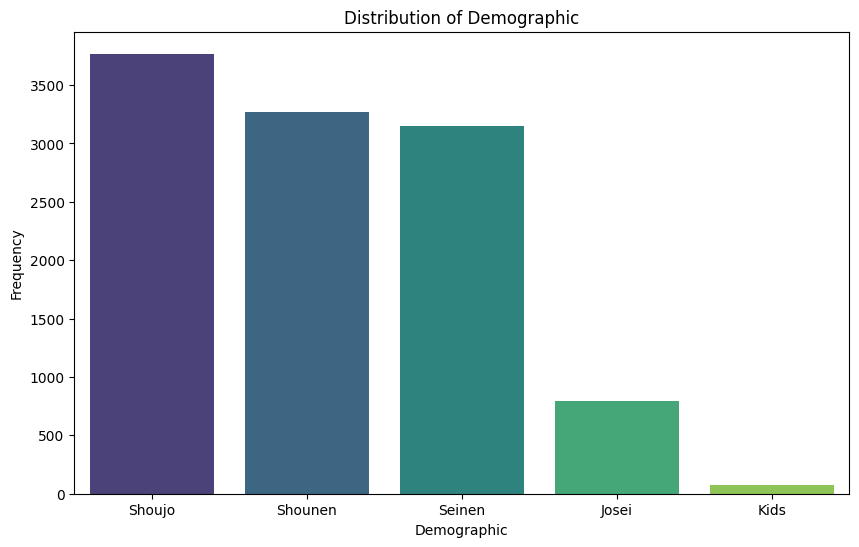

In [9]:
demographic_distribute = known_demographic_df['Demographic'].value_counts()

# Vẽ biểu đồ thanh với matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x=demographic_distribute.index, y=demographic_distribute.values, palette='viridis')
plt.title('Distribution of Demographic')
plt.xlabel('Demographic')
plt.ylabel('Frequency')
plt.show()

Nhóm thấy rằng các nhóm tuổi trong bộ dữ liệu bị mất cân bằng nặng, các bộ manga `Shoujo` có lượng cao nhất >3500 bộ, tuy nhiên các bộ manga như `Josei`, `Kids` lại có số lượng rất nhỏ < 1000 bộ, do đó ở các bước sau cần tiến hành thực hiện cân bằng lại dữ liệu

Nhóm sẽ chia tập dữ liệu thành 2 phần dataframe `X` và `y`, trong `X` chỉ xét những cột gồm `Score`, `Popularity`, `Types`, `Genres`, `Recommended` làm thuộc tính, còn `y` xét thuộc tính `Demographic`

In [10]:
X = known_demographic_df.drop(columns=['Title', 'Ranked', 'Volumes', 'Chapters', 'Status', 'Serialization', 'Author', 'Released date', 'Completed date', 'Demographic', 'Vote', 'Members', 'Favorite', 'Total Review', 'Mixed Feelings', 'Not Recommended'])
y = known_demographic_df['Demographic']
X

,Score,Popularity,Types,Genres,Recommended
0,9.47,1,Manga,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",252
1,9.31,23,Manga,"[""'Action'"", ""'Adventure'"", ""'Mystery'"", ""'Sup...",123
2,9.26,13,Manga,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",93
3,9.22,4,Manga,"[""'Action'"", ""'Adventure'"", ""'Fantasy'""]",190
4,9.16,29,Manga,"[""'Award Winning'"", ""'Drama'"", ""'Mystery'"", ""'...",69
...,...,...,...,...,...
19052,2.43,37132,Manga,"[""'Action'"", ""'Sci-Fi'""]",0
19053,2.43,25633,Manga,"[""'Action'"", ""'Drama'"", ""'Supernatural'"", ""'Me...",0
19054,2.43,35720,Manga,"[""'Comedy'"", ""'Romance'""]",0
19055,2.43,37133,Manga,"[""'Romance'""]",0


Nhóm sẽ làm sạch và xử lý cột `Genres` bằng cách đưa các giá trị trong cột `Genres` trở thành danh sách (list)

In [11]:
# Chuyển đổi kiểu dữ liệu dạng chuỗi của cột 'Genres' thành dạng list
X["Genres"] = X["Genres"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Xóa dấu ngoặc kép thừa xung quanh tên Genre (e.g., "'Horror'" -> "Horror")
X["Genres"] = X["Genres"].apply(lambda genres: [genre.strip("'") for genre in genres])

Nhóm thấy đặc trưng `Genres` là một thuộc tính ảnh hưởng khá nhiều đến quan trọng nên cần mã hóa cột này với phương pháp `MultiLabelBinarizer`. `Genres` là một đặc trưng quan trọng vì mỗi thể loại sẽ tạo ra một màu sắc riêng cho một bộ truyện và cho người đọc biết là một bộ truyện có phù hợp với sở thích của họ hay không.

In [12]:
mlb = MultiLabelBinarizer()

X = pd.concat([X,pd.DataFrame(mlb.fit_transform(X["Genres"]),columns=mlb.classes_, index=X.index)],axis=1)

X

,Score,Popularity,Types,Genres,Recommended,Action,Adult Cast,Adventure,Anthropomorphic,Avant Garde,...,Survival,Suspense,Team Sports,Time Travel,Urban Fantasy,Vampire,Video Game,Villainess,Visual Arts,Workplace
0,9.47,1,Manga,"[Action, Adventure, Award Winning, Drama, Fant...",252,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.31,23,Manga,"[Action, Adventure, Mystery, Supernatural, His...",123,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.26,13,Manga,"[Action, Adventure, Award Winning, Historical,...",93,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.22,4,Manga,"[Action, Adventure, Fantasy]",190,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.16,29,Manga,"[Award Winning, Drama, Mystery, Adult Cast, Ps...",69,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19052,2.43,37132,Manga,"[Action, Sci-Fi]",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19053,2.43,25633,Manga,"[Action, Drama, Supernatural, Mecha]",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19054,2.43,35720,Manga,"[Comedy, Romance]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19055,2.43,37133,Manga,[Romance],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Nhóm thực hiện xóa cột `Genres` đi vì không cần thiết nữa

In [13]:
X.drop(columns=['Genres'], inplace=True)

Nhóm thấy đặc trưng `Types` cũng là một thuộc tính cần thiết cho mô hình này nên cần mã hóa cột này với phương pháp `OneHotEncoder`. Vì cột `Types` chứa các giá trị có tính phân loại

In [14]:
type_scaler = OneHotEncoder()
scaled_type = type_scaler.fit_transform(X[['Types']]).toarray()
scaled_type_df = pd.DataFrame(scaled_type, columns=type_scaler.get_feature_names_out(['Types']))
scaled_type_df

,Types_Doujinshi,Types_Light Novel,Types_Manga,Types_Manhua,Types_Manhwa,Types_Novel,Types_One-shot
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
11047,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11048,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11049,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11050,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Sau khi mã hóa cột `Types` thành các cột thuộc tính mang đặc trưng, nhóm sẽ gộp nó lại với dataframe `X`, sau đó loại bỏ cột `Types` trong `X` vì không cần thiết nữa

In [15]:
scaled_type_df.index = X.index

X = pd.concat([X, scaled_type_df], axis=1)
X.drop(columns=['Types'], inplace=True)
X

,Score,Popularity,Recommended,Action,Adult Cast,Adventure,Anthropomorphic,Avant Garde,Award Winning,Boys Love,...,Villainess,Visual Arts,Workplace,Types_Doujinshi,Types_Light Novel,Types_Manga,Types_Manhua,Types_Manhwa,Types_Novel,Types_One-shot
0,9.47,1,252,1,0,1,0,0,1,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,9.31,23,123,1,0,1,0,0,0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,9.26,13,93,1,0,1,0,0,1,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,9.22,4,190,1,0,1,0,0,0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,9.16,29,69,0,1,0,0,0,1,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19052,2.43,37132,0,1,0,0,0,0,0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19053,2.43,25633,0,1,0,0,0,0,0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19054,2.43,35720,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19055,2.43,37133,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Nhóm sẽ chuẩn hóa các cột dạng số bằng phương pháp `StandardScaler` để xây dựng mô hình tốt hơn

In [16]:
# standard_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
scaled_X = standard_scaler.fit_transform(X)
scaled_X_df = pd.DataFrame(scaled_X, columns=X.columns)
scaled_X_df


,Score,Popularity,Recommended,Action,Adult Cast,Adventure,Anthropomorphic,Avant Garde,Award Winning,Boys Love,...,Villainess,Visual Arts,Workplace,Types_Doujinshi,Types_Light Novel,Types_Manga,Types_Manhua,Types_Manhwa,Types_Novel,Types_One-shot
0,4.107168,-1.422254,28.753729,1.850976,-0.096991,3.153185,-0.065351,-0.028548,5.700080,-0.097937,...,-0.053036,-0.049487,-0.072633,-0.021275,-0.110366,0.403582,-0.074498,-0.130117,-0.009513,-0.343101
1,3.846887,-1.419631,13.893861,1.850976,-0.096991,3.153185,-0.065351,-0.028548,-0.175436,-0.097937,...,-0.053036,-0.049487,-0.072633,-0.021275,-0.110366,0.403582,-0.074498,-0.130117,-0.009513,-0.343101
2,3.765550,-1.420824,10.438078,1.850976,-0.096991,3.153185,-0.065351,-0.028548,5.700080,-0.097937,...,-0.053036,-0.049487,-0.072633,-0.021275,-0.110366,0.403582,-0.074498,-0.130117,-0.009513,-0.343101
3,3.700480,-1.421897,21.611777,1.850976,-0.096991,3.153185,-0.065351,-0.028548,-0.175436,-0.097937,...,-0.053036,-0.049487,-0.072633,-0.021275,-0.110366,0.403582,-0.074498,-0.130117,-0.009513,-0.343101
4,3.602875,-1.418916,7.673452,-0.540256,10.310236,-0.317140,-0.065351,-0.028548,5.700080,-0.097937,...,-0.053036,-0.049487,-0.072633,-0.021275,-0.110366,0.403582,-0.074498,-0.130117,-0.009513,-0.343101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11047,-7.345167,3.005181,-0.274849,1.850976,-0.096991,-0.317140,-0.065351,-0.028548,-0.175436,-0.097937,...,-0.053036,-0.049487,-0.072633,-0.021275,-0.110366,0.403582,-0.074498,-0.130117,-0.009513,-0.343101
11048,-7.345167,1.634060,-0.274849,1.850976,-0.096991,-0.317140,-0.065351,-0.028548,-0.175436,-0.097937,...,-0.053036,-0.049487,-0.072633,-0.021275,-0.110366,0.403582,-0.074498,-0.130117,-0.009513,-0.343101
11049,-7.345167,2.836817,-0.274849,-0.540256,-0.096991,-0.317140,-0.065351,-0.028548,-0.175436,-0.097937,...,-0.053036,-0.049487,-0.072633,-0.021275,-0.110366,0.403582,-0.074498,-0.130117,-0.009513,-0.343101
11050,-7.345167,3.005300,-0.274849,-0.540256,-0.096991,-0.317140,-0.065351,-0.028548,-0.175436,-0.097937,...,-0.053036,-0.049487,-0.072633,-0.021275,-0.110366,0.403582,-0.074498,-0.130117,-0.009513,-0.343101


Thực hiện mã hóa các giá trị trong dataframe `y` (`Demographic`) bằng `LabelEncoder` để đưa vào mô hình

In [17]:
# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Chuyển 'Demographic' sang giá trị dạng số
y = label_encoder.fit_transform(y)

# Ánh xạ string labels sang giá trị numeric
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# In ra Label Mapping
print("Label Mapping:", label_mapping)

# Truy cập trực tiếp classes_ và transform methods
print("Classes in order:", label_encoder.classes_)

Label Mapping: {'Josei': 0, 'Kids': 1, 'Seinen': 2, 'Shoujo': 3, 'Shounen': 4}
Classes in order: ['Josei' 'Kids' 'Seinen' 'Shoujo' 'Shounen']


## 4. GIẢM ĐẶC TRƯNG DỮ LIỆU BẰNG LDA

Dataframe `X` lúc này gồm có 82 đặc trưng, nhóm sẽ kiểm tra xem những thuộc tính nào không ảnh hưởng quá lớn đến kết quả đầu ra `Demographic` để tiến hành loại bỏ các thuộc tính đó nhằm giúp mô hình trở nên đơn giản hơn cũng như tránh **overfitting**.

Để làm điều đó, nhóm sẽ tiến hành sử dụng thuật toán `LDA` nhằm tính mức độ quan trọng của thuộc tính `Importance` trong dataframe `X`

(82,)
            Feature  Importance
54          Romance    0.627613
1        Popularity    0.515026
56           School    0.497787
13           Comedy    0.392799
3            Action    0.317700
..              ...         ...
45  Organized Crime    0.005189
29   Idols (Female)    0.003120
19      Educational    0.001928
69    Urban Fantasy    0.001271
15      Delinquents    0.000484

[82 rows x 2 columns]
Transformed X_train_lda shape: (11052, 2)


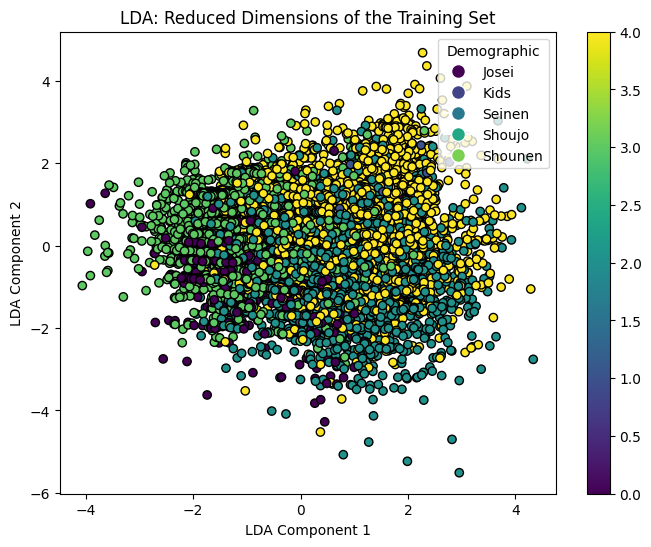

In [18]:
# Khởi tạo LDA và giảm kích thước
lda = LDA(n_components=2)  # Có thể điều chỉnh số lượng thành phần khi cần thiết
X_train_lda = lda.fit_transform(scaled_X, y)
feature_importance = lda.coef_[0]
print(feature_importance.shape)

feature_importance_df = pd.DataFrame({
    'Feature': X.keys(),  # Tên các đặc trưng từ DataFrame X
    'Importance': abs(feature_importance)
})

# Sắp xếp các đặc trưng theo mức độ quan trọng
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Importance'].abs().sort_values(ascending=False).index)

# In ra bảng các đặc trưng sắp xếp theo mức độ quan trọng
print(feature_importance_df)

# Kiểm tra dữ liệu sau khi chuẩn hóa
print("Transformed X_train_lda shape:", X_train_lda.shape)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.colorbar() 
plt.title('LDA: Reduced Dimensions of the Training Set')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(label_encoder.classes_)), markersize=10) 
           for i in range(len(label_encoder.classes_))]
labels = label_encoder.classes_  # Original class labels (e.g., 'Seinen', 'Shoujo')

# Thêm legend
plt.legend(handles, labels, title="Demographic", loc='upper right')
plt.show()

Bảng dưới đây mô tả các kết quả khi thực hiện bỏ các cột có Important lần lượt là 0.0, < 0.02, < 0.03, < 0.1, < 0.2. Mô hình sử dụng trong bảng này là mô hình ETC (Extra Tree Classifier)

| Feature_importance | Columns | No-Imbalanced-Handling | LABEL 0 (F1-Score) | LABEL 1 (F1-Score) | LABEL 2 (F1-Score) | LABEL 3 (F1-Score) | LABEL 4 (F1-Score) |
|----------|----------|----------|----------|----------|----------|----------|----------|
|0 | 82 | 0.564 | 0.211 | 0.341 | 0.512 | 0.692 | 0.536 |
|0.02 | 59 | 0.563 | 0.205 | 0.256 | 0.508 | 0.701 | 0.531 |
|**0.03** | **48** | **0.56** | **0.192** | **0.235** | **0.514** | **0.686** | **0.534** |
|0.1 | 20 | 0.534 | 0.201 | 0.25 | 0.481 | 0.669 | 0.499 |
|0.2 | 10 | 0.466 | 0.147 | 0.05 | 0.426 | 0.582 | 0.457 |

Có thể thấy nếu bỏ đi các đặc trưng có độ ảnh hưởng lớn hơn 0.03, nhóm có thể giảm số lượng thuộc tính từ 82 thuộc tính xuống còn 48 thuộc tính nhưng vẫn giữ được độ chính xác là ~0.56, điều này giúp mô hình giảm độ phức tạp cũng như giảm **overfitting**

Nhóm sẽ loại bỏ các đặc trưng có mức quan trọng trong khoảng `[0, 0.03]`, giữ lại các thuộc tính tốt để mô hình cho kết quả được chính xác hơn.

In [19]:
# Loại bỏ các đặc trưng có mức độ quan trọng nằm trong khoảng [-0.03, 0.03]
filtered_features = feature_importance_df[feature_importance_df['Importance'] > 0.03]
# Lấy các tên đặc trưng đã lọc và giữ lại chúng trong X_train_scaled
scaled_X_df = scaled_X_df[filtered_features['Feature']]
scaled_X_df

,Romance,Popularity,School,Comedy,Action,Villainess,Ecchi,Sci-Fi,Types_Manga,Types_One-shot,...,Magical Sex Shift,Love Status Quo,Anthropomorphic,Avant Garde,Types_Manhwa,Adult Cast,CGDCT,Fantasy,Types_Light Novel,Super Power
0,-0.922299,-1.422254,-0.585012,-0.705236,1.850976,-0.053036,-0.331285,-0.303649,0.403582,-0.343101,...,-0.078682,-0.086987,-0.065351,-0.028548,-0.130117,-0.096991,-0.04039,2.113902,-0.110366,-0.131192
1,-0.922299,-1.419631,-0.585012,-0.705236,1.850976,-0.053036,-0.331285,-0.303649,0.403582,-0.343101,...,-0.078682,-0.086987,-0.065351,-0.028548,-0.130117,-0.096991,-0.04039,-0.473059,-0.110366,-0.131192
2,-0.922299,-1.420824,-0.585012,-0.705236,1.850976,-0.053036,-0.331285,-0.303649,0.403582,-0.343101,...,-0.078682,-0.086987,-0.065351,-0.028548,-0.130117,-0.096991,-0.04039,-0.473059,-0.110366,-0.131192
3,-0.922299,-1.421897,-0.585012,-0.705236,1.850976,-0.053036,-0.331285,-0.303649,0.403582,-0.343101,...,-0.078682,-0.086987,-0.065351,-0.028548,-0.130117,-0.096991,-0.04039,2.113902,-0.110366,-0.131192
4,-0.922299,-1.418916,-0.585012,-0.705236,-0.540256,-0.053036,-0.331285,-0.303649,0.403582,-0.343101,...,-0.078682,-0.086987,-0.065351,-0.028548,-0.130117,10.310236,-0.04039,-0.473059,-0.110366,-0.131192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11047,-0.922299,3.005181,-0.585012,-0.705236,1.850976,-0.053036,-0.331285,3.293275,0.403582,-0.343101,...,-0.078682,-0.086987,-0.065351,-0.028548,-0.130117,-0.096991,-0.04039,-0.473059,-0.110366,-0.131192
11048,-0.922299,1.634060,-0.585012,-0.705236,1.850976,-0.053036,-0.331285,-0.303649,0.403582,-0.343101,...,-0.078682,-0.086987,-0.065351,-0.028548,-0.130117,-0.096991,-0.04039,-0.473059,-0.110366,-0.131192
11049,1.084247,2.836817,-0.585012,1.417965,-0.540256,-0.053036,-0.331285,-0.303649,0.403582,-0.343101,...,-0.078682,-0.086987,-0.065351,-0.028548,-0.130117,-0.096991,-0.04039,-0.473059,-0.110366,-0.131192
11050,1.084247,3.005300,-0.585012,-0.705236,-0.540256,-0.053036,-0.331285,-0.303649,0.403582,-0.343101,...,-0.078682,-0.086987,-0.065351,-0.028548,-0.130117,-0.096991,-0.04039,-0.473059,-0.110366,-0.131192


In [20]:
scaled_X = standard_scaler.fit_transform(scaled_X_df)

Thực hiện chia dữ liệu thành các tập train, test với tỷ lệ lần lượt là 70% train, 30% test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=42, stratify=y)  # 70% train, 30% test

Thực hiện kiểm tra phân phối của các giá trị trong cột `Demographic` trong tập train và test

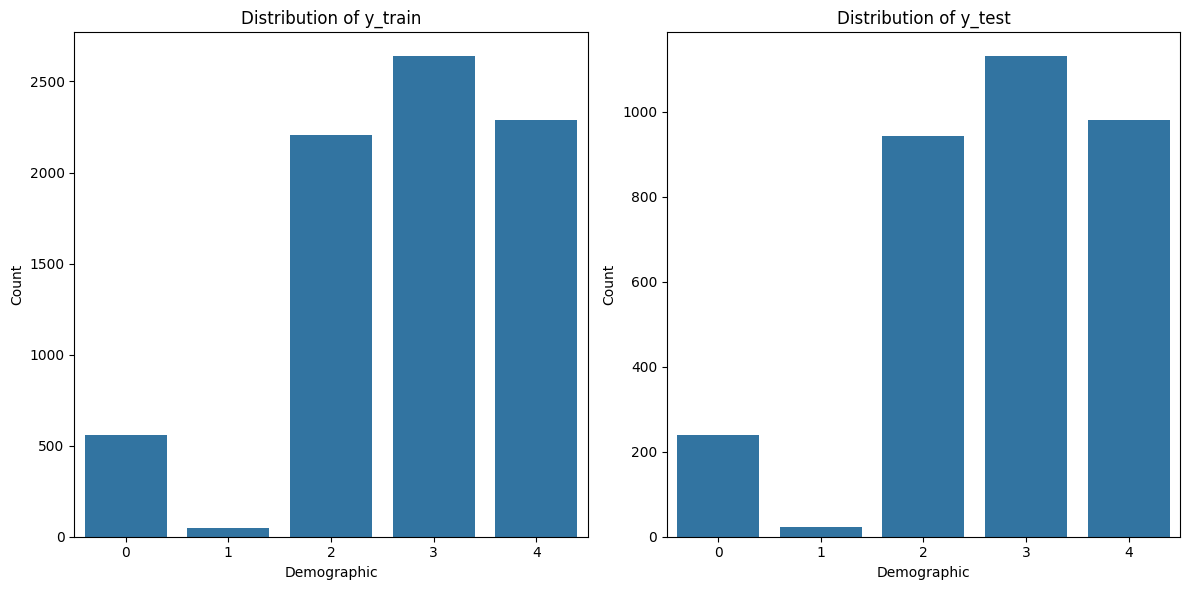

In [22]:
# Plot distribution of y_train and y_test
plt.figure(figsize=(12, 6))

# Plot distribution for y_train
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Distribution of y_train")
plt.xlabel("Demographic")
plt.ylabel("Count")

# Plot distribution for y_test
plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title("Distribution of y_test")
plt.xlabel("Demographic")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


## 5. XỬ LÝ DỮ LIỆU BẤT CÂN BẰNG `Upsampling` VÀ `Downsampling` VÀ SO SÁNH CÁC PHƯƠNG PHÁP

Từ biểu đồ trên có thể thấy phân phối của các giá trị trong cột `Demographic` không đều nhau, thể loại `Shoujo` đạt ngưỡng cao nhất (~3000) trong tập train, nhưng thể loại `Kids` chỉ đạt ngưỡng (~100), điều này làm cho dữ liệu bị mất cân bằng nặng

In [23]:
scaled_X_df.keys()

Index(['Romance', 'Popularity', 'School', 'Comedy', 'Action', 'Villainess',
       'Ecchi', 'Sci-Fi', 'Types_Manga', 'Types_One-shot', 'Girls Love',
       'Slice of Life', 'Score', 'Workplace', 'Types_Novel', 'Sports',
       'Adventure', 'Visual Arts', 'Historical', 'Supernatural', 'Memoir',
       'Mecha', 'Iyashikei', 'Medical', 'Team Sports', 'Suspense', 'Harem',
       'Boys Love', 'Idols (Male)', 'Recommended', 'Gourmet', 'Martial Arts',
       'Showbiz', 'Military', 'Racing', 'Combat Sports', 'Video Game',
       'Samurai', 'Magical Sex Shift', 'Love Status Quo', 'Anthropomorphic',
       'Avant Garde', 'Types_Manhwa', 'Adult Cast', 'CGDCT', 'Fantasy',
       'Types_Light Novel', 'Super Power'],
      dtype='object')

Dưới đây là đoạn code thực hiện phương pháp `Upsampling` để cho ra kết quả so sánh ở bảng dưới.

Nếu bạn muốn sử dụng phương pháp này để đối chiếu với kết quả trong bảng, vui lòng mở comment cho đoạn code dưới, và khóa comment cho đoạn code `Downsampling`, mở comment cho đoạn code `Classweight`, chỉnh tham số `class_weight=None`

In [24]:
# y = pd.Series(y)

# # Xác định các lớp chiếm ưu thế và lớp ít mẫu hơn
# majority_classes = y.value_counts().index[:-2]  # Các lớp chiếm ưu thế (tất cả trừ lớp ít mẫu nhất)
# minority_class = y.value_counts().index[-2]  # Lớp ít mẫu hơn (lớp cuối cùng trong phân phối)

# # 2. Tách các lớp trong X và y
# X_majority = scaled_X_df[y.isin(majority_classes)]  # Các mẫu của lớp chiếm ưu thế
# y_majority = y[y.isin(majority_classes)]

# X_minority = scaled_X_df[y == minority_class]  # Các mẫu của lớp ít mẫu
# y_minority = y[y == minority_class]

# # 3. Downsampling các lớp chiếm ưu thế sao cho chúng có số lượng mẫu bằng lớp ít mẫu hơn
# X_majority_downsampled = []
# y_majority_downsampled = []

# # Lặp qua từng lớp chiếm ưu thế để thực hiện downsampling
# for class_label in majority_classes:
#     X_class = X_majority[y_majority == class_label]
#     y_class = y_majority[y_majority == class_label]
    
#     # Downsample cho từng lớp chiếm ưu thế
#     X_class_downsampled, y_class_downsampled = resample(X_class, y_class,
#                                                          replace=False,  # Không lặp lại mẫu
#                                                          n_samples=len(X_minority),  # Cân bằng với lớp minority
#                                                          random_state=42)  # Để tái tạo kết quả
    
#     X_majority_downsampled.append(X_class_downsampled)
#     y_majority_downsampled.append(y_class_downsampled)

# # Kết hợp tất cả các lớp chiếm ưu thế đã downsampled với lớp ít mẫu hơn
# X_balanced = pd.concat([*X_majority_downsampled, X_minority], axis=0)
# y_balanced = pd.concat([*y_majority_downsampled, y_minority], axis=0)

# # 4. Xáo trộn dữ liệu lại để tránh sự xếp hàng
# X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# # Kiểm tra độ cân bằng của lớp trong tập huấn luyện
# print(f"Balanced y distribution:\n{y_balanced.value_counts()}")

# # In ra kích thước của tập huấn luyện đã cân bằng
# print(f"Balanced X shape: {X_balanced.shape}")
# print(f"Balanced y shape: {y_balanced.shape}")

# # 4. Nối các hàng mà có y == 1 vào X_balanced và y_balanced
# X_class_1 = scaled_X_df[y == 1]  # Các mẫu có y == 1
# y_class_1 = y[y == 1]

# X_balanced = pd.concat([X_balanced, X_class_1], axis=0)
# y_balanced = pd.concat([y_balanced, y_class_1], axis=0)

# # 5. Xáo trộn dữ liệu lại để tránh sự xếp hàng
# X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# # Kiểm tra độ cân bằng của lớp trong tập huấn luyện
# print(f"Balanced y distribution:\n{y_balanced.value_counts()}")

# # In ra kích thước của tập huấn luyện đã cân bằng
# print(f"Balanced X shape: {X_balanced.shape}")
# print(f"Balanced y shape: {y_balanced.shape}")

Dưới đây là đoạn code thực hiện phương pháp `Downsampling` để cho ra kết quả so sánh ở bảng dưới.

Nếu bạn muốn sử dụng phương pháp này để đối chiếu với kết quả trong bảng, vui lòng mở comment cho đoạn code dưới, và khóa comment cho đoạn code `Upsampling`, mở comment cho đoạn code `Classweight`, chỉnh tham số `class_weight=None`

In [25]:
# # import pandas as pd
# # from sklearn.utils import resample, shuffle

# # Giả sử y là NumPy array hoặc list, cần chuyển nó thành Pandas Series
# y_train = pd.Series(y_train)

# # 1. Tính toán số lượng mẫu của các lớp
# class_counts = y_train.value_counts()

# # 2. Lọc ra 2 lớp ít mẫu nhất (có thể là lớp ít mẫu nhất và lớp ít thứ 2)
# minority_classes = class_counts.nsmallest(2).index  # Lớp ít mẫu nhất và lớp ít thứ hai

# # In ra thông tin về các lớp ít mẫu
# print(f"Minority classes: {minority_classes}")

# # 3. Tách các lớp trong X và y
# X_minority_1 = X_train[y_train == minority_classes[0]]  # Các mẫu của lớp ít mẫu nhất
# y_minority_1 = y_train[y_train == minority_classes[0]]

# X_minority_2 = X_train[y_train == minority_classes[1]]  # Các mẫu của lớp ít mẫu thứ 2
# y_minority_2 = y_train[y_train == minority_classes[1]]

# # 4. Xác định số lượng mẫu của lớp chiếm ưu thế (hoặc số mẫu bạn muốn upsample về)
# majority_class = class_counts.idxmax()  # Lớp chiếm ưu thế (có số mẫu lớn nhất)
# X_majority = X_train[y_train == majority_class]
# y_majority = y_train[y_train == majority_class]

# # 5. Upsample cho 2 lớp ít mẫu nhất sao cho chúng có số lượng mẫu bằng với lớp chiếm ưu thế
# X_minority_1_upsampled, y_minority_1_upsampled = resample(X_minority_1, y_minority_1,
#                                                             replace=True,  # Cho phép lặp lại mẫu
#                                                             n_samples=len(X_majority),  # Cân bằng với lớp chiếm ưu thế
#                                                             random_state=42)

# X_minority_2_upsampled, y_minority_2_upsampled = resample(X_minority_2, y_minority_2,
#                                                             replace=True,  # Cho phép lặp lại mẫu
#                                                             n_samples=len(X_majority),  # Cân bằng với lớp chiếm ưu thế
#                                                             random_state=42)

# # 6. Chuyển các mảng numpy thành DataFrame hoặc Series
# X_minority_1_upsampled = pd.DataFrame(X_minority_1_upsampled, columns=scaled_X_df.columns)
# X_minority_2_upsampled = pd.DataFrame(X_minority_2_upsampled, columns=scaled_X_df.columns)
# X_majority = pd.DataFrame(X_majority, columns=scaled_X_df.columns)

# y_minority_1_upsampled = pd.Series(y_minority_1_upsampled)
# y_minority_2_upsampled = pd.Series(y_minority_2_upsampled)
# y_majority = pd.Series(y_majority)

# # 7. Kết hợp lại các lớp đã upsampled với lớp chiếm ưu thế
# X_balanced = pd.concat([X_majority, X_minority_1_upsampled, X_minority_2_upsampled], axis=0)
# y_balanced = pd.concat([y_majority, y_minority_1_upsampled, y_minority_2_upsampled], axis=0)

# # 8. Xáo trộn dữ liệu lại để tránh sự xếp hàng
# X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# # Kiểm tra độ cân bằng của lớp trong tập huấn luyện
# print(f"Balanced y distribution:\n{y_balanced.value_counts()}")

# # In ra kích thước của tập huấn luyện đã cân bằng
# print(f"Balanced X shape: {X_balanced.shape}")
# print(f"Balanced y shape: {y_balanced.shape}")


# # 4. Nối các hàng mà có y == 1 vào X_balanced và y_balanced
# X_class_2 = X_train[y_train == 2]  # Các mẫu có y == 1
# y_class_2 = y_train[y_train == 2]

# X_class_4 = X_train[y_train == 4]  # Các mẫu có y == 1
# y_class_4 = y_train[y_train == 4]

# X_class_2 = pd.DataFrame(X_class_2, columns=scaled_X_df.columns)
# X_class_4 = pd.DataFrame(X_class_4, columns=scaled_X_df.columns)

# X_balanced = pd.concat([X_balanced, X_class_2], axis=0)
# y_balanced = pd.concat([y_balanced, y_class_2], axis=0)

# X_balanced = pd.concat([X_balanced, X_class_4], axis=0)
# y_balanced = pd.concat([y_balanced, y_class_4], axis=0)

# # 5. Xáo trộn dữ liệu lại để tránh sự xếp hàng
# X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# # Kiểm tra độ cân bằng của lớp trong tập huấn luyện
# print(f"Balanced y distribution:\n{y_balanced.value_counts()}")

# # In ra kích thước của tập huấn luyện đã cân bằng
# print(f"Balanced X shape: {X_balanced.shape}")
# print(f"Balanced y shape: {y_balanced.shape}")

In [26]:
# X_clean_train, y_clean_train = X_smoteenn_df, y_smoteenn_df
# X_clean_train, y_clean_train = X_balanced, y_balanced
X_clean_train, y_clean_train = X_train, y_train

Dưới đây là đoạn code thực hiện phương pháp `Classweight` để cho ra kết quả so sánh ở bảng dưới.

Nếu bạn muốn sử dụng phương pháp này để đối chiếu với kết quả trong bảng, vui lòng mở comment cho đoạn code dưới, và khóa comment cho đoạn code `Upsampling`, `Downsampling`

In [27]:
# model = ExtraTreesClassifier(class_weight='balanced', random_state=42)
# model.fit(X_clean_train, y_clean_train)
# y_pred = model.predict(X_test)
# mae = mean_absolute_error(y_test, y_pred)
# print('Mean Absolute Error:', mae)

In [28]:
# conf_matrix = confusion_matrix(y_test, y_pred)

# conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# # Classification Report
# class_report = classification_report(y_test, y_pred, digits=3)
# print(f"ETC Classification Report:\n{class_report}")

# # Plot Confusion Matrix using a heatmap
# plt.figure(figsize=(6, 5))
# sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
# plt.title("Normalize Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.tight_layout()
# plt.show()

| Before Fine-Tuning | Accuracy | LABEL 0 (F1-Score) | LABEL 1 (F1-Score) | LABEL 2 (F1-Score) | LABEL 3 (F1-Score) | LABEL 4 (F1-Score) |
|----------|----------|----------|----------|----------|----------|----------|
| **DOWNSAMPLING** | **0.613** | **0.522** | **0.557** | **0.542** | **0.707** | **0.629** |
| UPSAMPLING | 0.563 | 0.202 | 0.229 | 0.51 | 0.691 | 0.538 |
| CLASS-WEIGHT | 0.564 | 0.21 | 0.222 | 0.519 | 0.693 | 0.532 |

- Có thể thấy độ chính xác khi sử dụng phương pháp `Downsampling` là cao nhất (0.613), thế nhưng rõ ràng khi sử dụng phương pháp downsampling, một số lượng các mẫu sẽ bị loại bỏ, điều này có thể tăng nguy cơ mô hình giảm đi tính khái quát hóa trong quá trình học
- Sử dụng phương pháp `Upsampling` có thể khắc phục nhược điểm của `Downsampling`, tuy nhiên các chỉ số `Accuracy` cũng như `F1-score` của phương pháp này không được cao cho lắm, điều này có thể do các mẫu thiểu số bị trùng quá nhiều khiến mô hình giảm khả năng học đặc trưng từ lớp này
- Để khắc phục nhược điểm của 2 phương pháp trên, đề xuất sử dụng phương pháp `Class weight`, giữ lại phân phối của các lớp tuy nhiên đánh trọng số cho các label, các chỉ số `Accuracy` cũng như `F1-score` của phương pháp này cao hơn `Upsampling` nhưng lại thấp hơn `Downsampling`

## 6. XÂY DỰNG MÔ HÌNH

Trong đồ án này, nhóm sử dụng mô hình cây ETC (ExtraTreesClassifier) để thực hiện phân loại các bộ truyện

Cây ETC sử dụng các nguyên lý của cây quyết định và cải tiến thêm bằng cách tăng độ ngẫu nhiên trong quá trình xây dựng cây, nhằm nâng cao hiệu suất mô hình.

Nhóm sẽ Fine-tuning Extra Trees Classifier

In [29]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}
grid_search = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_clean_train, y_clean_train)

# Best model from grid search
etc_best = grid_search.best_estimator_
etc_best


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


ExtraTreesClassifier(class_weight='balanced', max_features='log2',
                     min_samples_split=5, n_estimators=200, random_state=42)

In [30]:
model = grid_search.best_estimator_
model.fit(X_clean_train, y_clean_train)
y_pred = model.predict(X_test)

ETC Classification Report:
              precision    recall  f1-score   support

           0      0.221     0.301     0.255       239
           1      0.184     0.409     0.254        22
           2      0.549     0.503     0.525       944
           3      0.696     0.695     0.696      1131
           4      0.549     0.531     0.540       980

    accuracy                          0.562      3316
   macro avg      0.440     0.488     0.454      3316
weighted avg      0.573     0.562     0.566      3316



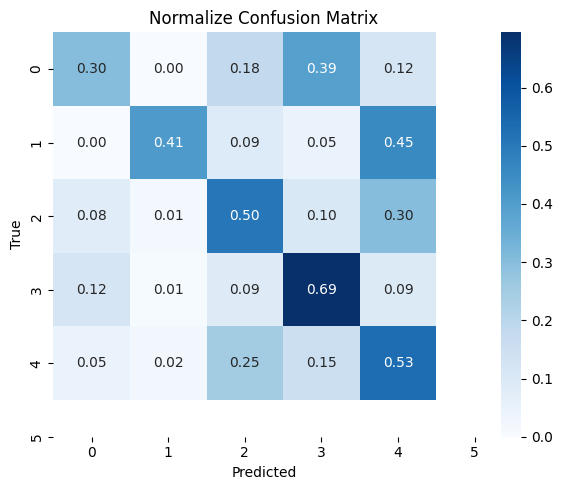

In [31]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Classification Report
class_report = classification_report(y_test, y_pred, digits=3)
print(f"ETC Classification Report:\n{class_report}")

# Plot Confusion Matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
plt.title("Normalize Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

| After Fine-Tuning | Accuracy | LABEL 0 (F1-Score) | LABEL 1 (F1-Score) | LABEL 2 (F1-Score) | LABEL 3 (F1-Score) | LABEL 4 (F1-Score) |
|----------|----------|----------|----------|----------|----------|----------|
| DOWNSAMPLING | 0.54 | 0.336 | 0.375 | 0.54 | 0.618 | 0.562 |
| UPSAMPLING | 0.575 | 0.211 | 0.27 | 0.525 | 0.702 | 0.548 |
| **CLASS-WEIGHT** | **0.562** | **0.255** | **0.254** | **0.525** | **0.696** | **0.54** |


- Sau khi thực hiện Finetune mô hình, Có thể thấy độ chính xác khi sử dụng phương pháp `Downsampling` là thấp nhất (0.54)
- Chỉ số `Accuracy` của phương pháp `Class weight` (0.562) tuy không bằng phương pháp `Upsampling` (0.575) tuy nhiên các chỉ số `F1-score` lại vượt trội hơn `Upsampling`

In [32]:
df = pd.DataFrame({
    'Actual': y_pred,
    'Predicted': y_test,
})
df.head(20)

,Actual,Predicted
0,2,2
1,3,2
2,2,2
3,3,3
4,0,2
5,2,3
6,4,2
7,3,3
8,2,2
9,0,3
